<h1 align=center><font size=5> Speech Recognition </font></h1>

## Table of contents

- [Objective](#obj)
- [Data](#data)
- [Data Preprocessing](#data_preproc)
- [Time Domain Model](#time_model)
- [Time-Frequency Domain Model](#time_freq_model)

## Objective <a id='obj'></a>

In this notebook, we will deal with audio/voice singals. Accordingly, we will build time domain and time-frequency domain models for the purpose of speech classification.

## Data <a id='data'></a>

Here I am using the  Free Spoken Digit Dataset (FSDD), so called "speech MNIST" dataset. The dataset contains a set of recorded spoken digits in wav formats. Link to this dataset in the following URL: https://github.com/Jakobovski/free-spoken-digit-dataset

&#x270d; Download the dataset



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#!pip install librosa

&#x270d; LibROSA is a python package for music and audio analysis

 Loading an audio file using librosa.load. To preserve the native sampling rate of the file,here we are using  **`sr=None`.**



In [0]:
import os
import librosa # !pip install librosa

audio_path = os.path.join(os.getcwd(), '/content/drive/My Drive/free-spoken-digit-dataset-master/free-spoken-digit-dataset-master/recordings')
audio_files = os.listdir(audio_path) 

sample_audio_file = audio_files[500] # choose a ranodm audio file

sample_audio_path = audio_path + '/' + sample_audio_file


X, sr = librosa.load(sample_audio_path, sr= None)


&#x270d; Displaying the length of the audio array and sampling rate.

In [0]:
print('Audio signal shape:', X.shape  )
print('Sampling rate: {} Hz'.format(sr))

Audio signal shape: (3428,)
Sampling rate: 8000 Hz


&#x270d; Length of audio signal in seconds
<br>


In [0]:
print('Audio length: {} seconds'.format(X.shape[0]/sr ))

Audio length: 0.4285 seconds


&#x270d; Playing the chosen audio file 

In [0]:
from IPython.display import Audio

Audio(X, rate=sr)

&#x270d; Plotting the audio signal in time domain.

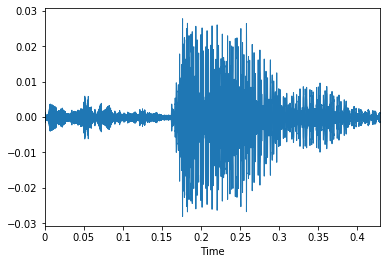

In [0]:
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

librosa.display.waveplot(X, sr=sr)

&#x270d; Displaying the audio signal's spectrogram on a logarithmic scale using *librosa.stft*. Note that, the Short-Time Fourier Transform (STFT) represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.






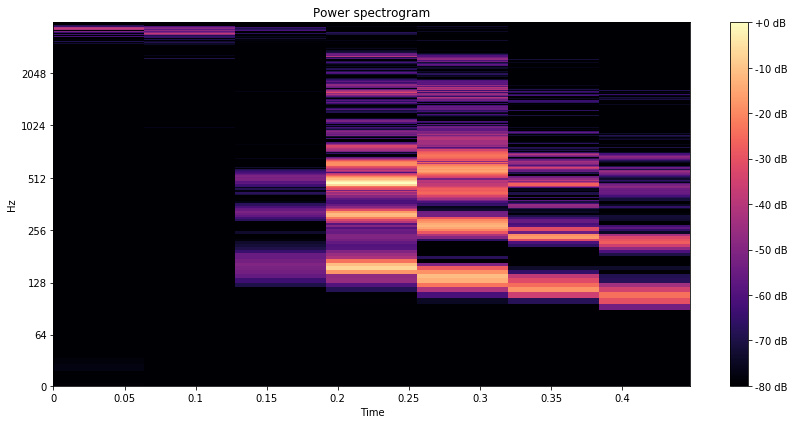

In [0]:
import numpy as np

n_fft = 1024
hop_length = 512
stft = librosa.stft(X, n_fft=n_fft, hop_length=hop_length)
stft_magnitude, stft_phase = librosa.magphase(stft)
stft_magnitude_dB = librosa.amplitude_to_db(stft_magnitude * stft_magnitude, ref = np.max)
#Xdb = librosa.amplitude_to_db(abs(stft))
#stft_magnitude_dB = librosa.magnitude_dB(abs(X))

plt.figure(figsize=(12, 6))
librosa.display.specshow(stft_magnitude_dB, x_axis='time' ,y_axis='log', sr=sr,hop_length= hop_length)
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

&#x270d; Hop length in seconds

In [0]:
print('Hop length: {} seconds'.format(hop_length/sr)) 

Hop length: 0.064 seconds


## Data Preprocessing <a id='data_preproc'></a>

&#x270d; Finding duration in seconds and sampling rate. Then, plotting their distributions.

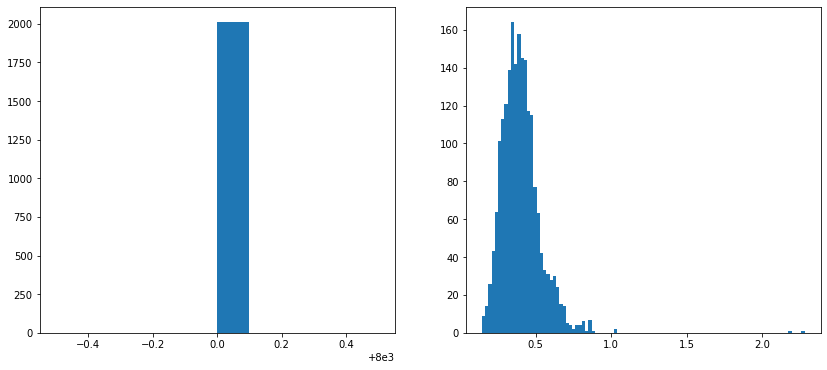

In [0]:
audio_path = os.path.join(os.getcwd(), '/content/drive/My Drive/free-spoken-digit-dataset-master/free-spoken-digit-dataset-master/recordings')
audio_files = os.listdir(audio_path)

all_audios_sr = []
all_audios_duration = []
for audio_file in audio_files:
  audio, sr = librosa.load(audio_path + '/'+ audio_file, sr = None)

  all_audios_sr.append(sr)
  all_audios_duration.append(len(audio)/sr)

all_audios_duration = np.asarray(all_audios_duration)
all_audios_sr = np.asarray(all_audios_sr)

plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
plt.hist(all_audios_sr);

plt.subplot(1,2,2)
plt.hist(all_audios_duration, bins =100);


&#x270d; Clipping or padding audio signals to have one second duration for all audios. Extracting the audio labels as well and keeping audio signals from speaker 'jackson' for test set, and the rest speakers for training.

Dataformat Number_NAME_recordnumber.wav

In [0]:
audio_duration_sec = 1

pad = lambda a, n: a[:n] if a.shape[0] > n else np.hstack((a, np.zeros(n - a.shape[0])))

X_train, y_train = [], []
X_test, y_test = [], []
for audio_file in audio_files:
    
    audio, sr = librosa.load(audio_path +'/'+ audio_file, sr = None)
    
    X = pad(audio, int(audio_duration_sec*sr))
    label = audio_file.split('_')[0]
    speaker = audio_file.split('_')[1]
    
    if (speaker=='jackson'):
        X_test.append(X)
        y_test.append(label)
    else:
        X_train.append(X)
        y_train.append(label)
        
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [0]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (1510, 8000)
X_test shape: (500, 8000)


&#x270d; Converting the labels to a one-hot vector. 

In [0]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_test =  to_categorical(y_test)

In [0]:
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (1510, 10)
y_test shape: (500, 10)


## Time Domain Model <a id='time_model'></a>

&#x270d; Building a model based on time domain input signals and evaluating its classification performance. 

In [0]:
# Creating the model
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(256, activation='relu', input_dim= X_train.shape[1]))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation ='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 256)               2048256   
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 10)               

In [0]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split =0.2, shuffle=True, verbose=1)



Train on 1208 samples, validate on 302 samples
Epoch 1/100
1208/1208 [==============================] - 2s 1ms/step - loss: 2.2883 - acc: 0.1316 - val_loss: 2.4459 - val_acc: 0.0000e+00
Epoch 2/100
1208/1208 [==============================] - 1s 673us/step - loss: 2.1941 - acc: 0.1614 - val_loss: 2.9168 - val_acc: 0.0000e+00
Epoch 3/100
1208/1208 [==============================] - 1s 667us/step - loss: 2.0537 - acc: 0.2144 - val_loss: 3.6565 - val_acc: 0.0000e+00
Epoch 4/100
1208/1208 [==============================] - 1s 667us/step - loss: 1.8706 - acc: 0.3030 - val_loss: 4.3902 - val_acc: 0.0000e+00
Epoch 5/100
1208/1208 [==============================] - 1s 672us/step - loss: 1.6987 - acc: 0.3667 - val_loss: 4.9740 - val_acc: 0.0000e+00
Epoch 6/100
1208/1208 [==============================] - 1s 664us/step - loss: 1.4961 - acc: 0.4776 - val_loss: 5.5420 - val_acc: 0.0000e+00
Epoch 7/100
1208/1208 [==============================] - 1s 662us/step - loss: 1.2928 - acc: 0.5654 - val_los

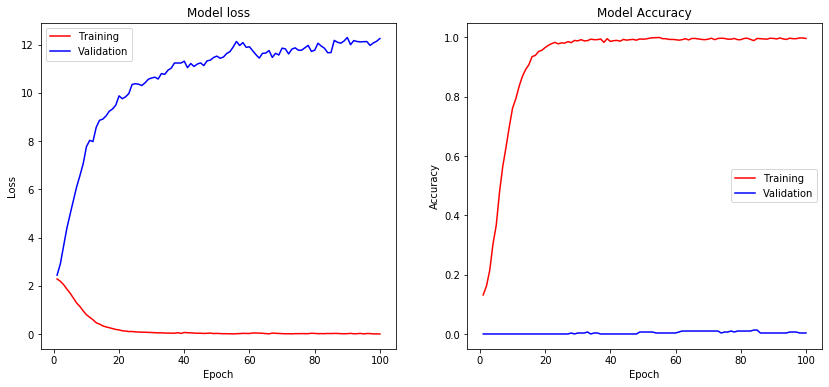

In [0]:
# Plotting loss and accuracy versus training epochs
def plot_model(history):
    tr_loss = history.history['loss']
    tr_accuracy = history.history['acc']

    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_acc']

    epochs= range(1, len(tr_loss)+1)

    plt.figure(figsize =(14,6))
    plt.subplot(1,2,1)
    plt.plot(epochs, tr_loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='best')

    plt.subplot(1,2,2)
    plt.plot(epochs, tr_accuracy, 'r')
    plt.plot(epochs, val_accuracy, 'b')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='best')
    plt.show()
    

    
plot_model(history)

In [0]:
# Evaluating the model over test set
score,acc = model.evaluate(X_test, y_test, verbose=0)

print('Test score:',score )
print('Test accuracy:',acc )

Test score: 13.190985580444336
Test accuracy: 0.14200000047683717


## Time-Frequency Domain Model <a id='time_freq_model'></a>

&#x270d; Now, creating a model based on time-frequency domain input signals and evaluating its performance.

Frequency domain will be obtained using abs(the output from stft) 

In [0]:
audio_path = os.path.join(os.getcwd(), '/content/drive/My Drive/free-spoken-digit-dataset-master/free-spoken-digit-dataset-master/recordings')
audio_files = os.listdir(audio_path) 

X_train, y_train = [], []
X_test, y_test = [], []
for audio_file in audio_files:
    
    audio, sr = librosa.load(audio_path +'/'+ audio_file, sr = None)
    
    X = pad(audio, int(audio_duration_sec*sr))
    
    spectrogram = np.abs(librosa.stft(X))
    
    label = audio_file.split('_')[0]
    speaker = audio_file.split('_')[1]
    
    if (speaker=='jackson'):
        X_test.append(spectrogram)
        y_test.append(label)
    else:
        X_train.append(spectrogram)
        y_train.append(label)
        
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [0]:
X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1)

In [0]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (1510, 1025, 16, 1)
X_test shape: (500, 1025, 16, 1)


In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (1510, 10)
y_test shape: (500, 10)


In [0]:
# Creating the model
from keras.layers import Conv2D, MaxPooling2D, Flatten

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=1, activation='relu', input_shape=X_train[0].shape))
model.add(MaxPooling2D(pool_size =(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10,activation='softmax'))
model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 1023, 14, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 511, 7, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 511, 7, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 509, 5, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 254, 2, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 254, 2, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32512)            

In [0]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2, shuffle=True, verbose= 1)

Train on 1208 samples, validate on 302 samples
Epoch 1/15
1208/1208 [==============================] - 21s 18ms/step - loss: 1.5967 - acc: 0.4561 - val_loss: 5.0200 - val_acc: 0.0000e+00
Epoch 2/15
1208/1208 [==============================] - 20s 17ms/step - loss: 0.9330 - acc: 0.7136 - val_loss: 6.1741 - val_acc: 0.0000e+00
Epoch 3/15
1208/1208 [==============================] - 20s 17ms/step - loss: 0.6383 - acc: 0.7848 - val_loss: 7.1236 - val_acc: 0.0066
Epoch 4/15
1208/1208 [==============================] - 20s 17ms/step - loss: 0.5491 - acc: 0.8336 - val_loss: 7.8618 - val_acc: 0.0728
Epoch 5/15
1208/1208 [==============================] - 20s 17ms/step - loss: 0.4423 - acc: 0.8618 - val_loss: 7.5281 - val_acc: 0.0530
Epoch 6/15
1208/1208 [==============================] - 20s 17ms/step - loss: 0.3031 - acc: 0.9048 - val_loss: 9.4100 - val_acc: 0.0596
Epoch 7/15
1208/1208 [==============================] - 20s 17ms/step - loss: 0.2627 - acc: 0.9172 - val_loss: 9.2066 - val_acc: 

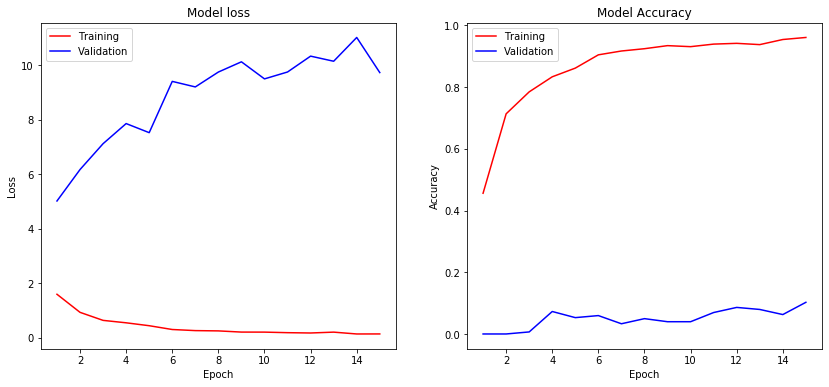

In [0]:
plot_model(history)

In [0]:
print('Test score:', score)
print('Test accuracy:',acc )

Test score: 13.190985580444336
Test accuracy: 0.14200000047683717
